# 2.1 线性回归的从零开始实现
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [26]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 2.1.1构造数据集
根据带有噪声的线性模型构造一个人造数据集，我们使用线性模型参数w=[2,-3.4],b=4.2和噪声项$\epsilon$生成数据集及其标签。
$$
\mathbf{y}=\mathbf{X} \mathbf{w}+b+\epsilon
$$

In [27]:
def synthetic_data(w,b,num_examples):
    """生成y=Xw+b+噪声"""
    X=torch.normal(0,1,(num_examples,len(w)))#均值为0，方差为1的随机数，大小为num_examples,列数为w的长度）
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)#噪声项为服从均值为0的正态分布，标准差为0.01
    
    return X,y.reshape((-1,1))# 最后把X，y做成列向量返回
                   
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)


In [28]:
print('features:',features[0],'\nlabel:',labels[0])#看一下第0个样本

features: tensor([-0.9903, -0.9685]) 
label: tensor([5.5151])


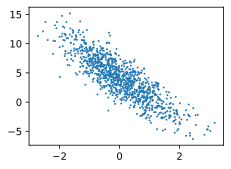

In [29]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),#detach分离出数值，没有梯度
               labels.detach().numpy(),1)

In [30]:
#features

In [31]:
#features[:,1]

## 2.1.2 读取数据集

定义一个data_iter函数。输入为函数接受量大小、特征矩阵和标签向量，生成大小为batch_size的小批量。

In [32]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=(range(num_examples))
    
    random.shuffle(indices)#随机打乱
    
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(
            indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

batch_size=10

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break
    

tensor([[ 0.7045, -0.0954],
        [-0.9353, -1.2589],
        [ 1.7039, -0.4179],
        [-1.0127, -0.6612],
        [-0.6550, -0.0190],
        [ 1.1398, -0.2984],
        [ 0.6446,  0.6703],
        [ 1.2637,  0.4631],
        [-1.5332, -0.8621],
        [-1.1849, -0.6343]]) 
 tensor([[5.9273],
        [6.6107],
        [9.0341],
        [4.4204],
        [2.9484],
        [7.4877],
        [3.2092],
        [5.1611],
        [4.0615],
        [3.9912]])


## 2.1.3 定义初始化模型参数

In [33]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)#输入为2，所以参数也是长为2的向量
b=torch.zeros(1,requires_grad=True)#对偏差进行更新

## 2.1.4 定义模型

In [34]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

## 2.1.5 定义损失函数

In [35]:
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

## 2.1.6 定义优化算法

小批量优化算法：每一步中，使用从数据集中抽取的一个小批量，根据参数计算损失的梯度，接着朝着减少损失的方向更新我们的参数。

In [36]:
def sgd(params,lr,batch_size):#给定所有参数（包含w和b），学习率，batch_size
    """小批量随机"""
    with torch.no_grad():#更新的时候不用计算梯度
        for param in params:
            param-=lr*param.grad/batch_size
            param.grad.zero_()

## 2.1.7 训练

In [37]:
#制定超参数
lr= 0.03
num_epochs=3
net=linreg
loss=squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)

        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)#features是全部的权重向量
        print(f'epoch{epoch+1}, loss{float(train_l.mean()):f}')


epoch1, loss0.061552
epoch2, loss0.000317
epoch3, loss0.000050


## 2.1.8 计算误差

In [38]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 0.0006, -0.0005], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0010], grad_fn=<RsubBackward1>)
